# Medication Adherence

A pharmacy analytics team is studying patients on two different medication regimens for the same chronic condition.
* **Regimen A**: newer drug, better tolerated; patients report lower side-effect burden and stay highly adherent.
* **Regimen B**: older/cheaper drug; patients report higher side-effect burden and tend to skip doses, but not in a perfectly straight-line way (it’s messy, human behavior).

When we plot **medication adherence (%)** vs **side-effect burden (0–10 scale)**, we see two “bands” of patients that curve — not nice circles.

Your task: use clustering to find these two natural groups. K-means will try, but DBSCAN should do better because the groups are non-spherical and density-based.

## Learning Objectives

By the end, students should be able to:
1.	Explain why k-means struggles with non-spherical clusters.
2.	Run DBSCAN on 2D data and interpret labels (including -1 noise).
3.	Tune eps and min_samples and describe the effect.
4.	Connect clusters back to a healthcare story (two different medication experiences).

## Steps
1. Explore the data
2. Try to cluster using K-Means
3. Scale the data and cluster using DBSCAN
4. Discussion

## 1. Explore the data

Load the data and explore the variables and their relationship.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


meds = pd.read_csv("adherence_vs_side_effects.txt", sep="|")
meds.head()

,side_effect_burden,med_adherence_pct,sim_regimen
0,3.75,66.0,1
1,6.86,67.3,0
2,1.25,86.1,0
3,3.68,94.2,0
4,0.26,74.0,0


<Axes: xlabel='side_effect_burden', ylabel='med_adherence_pct'>

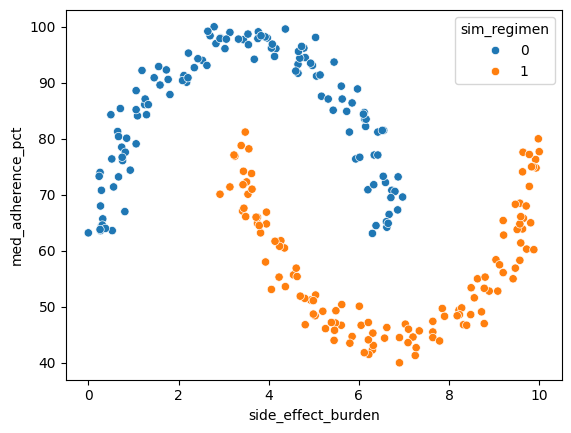

In [2]:
sns.scatterplot(meds, x='side_effect_burden', y='med_adherence_pct', hue='sim_regimen')

## 2. Try using simple K-Means Clustering

...to show what we should expect already. It won't work.

<Axes: xlabel='side_effect_burden', ylabel='med_adherence_pct'>

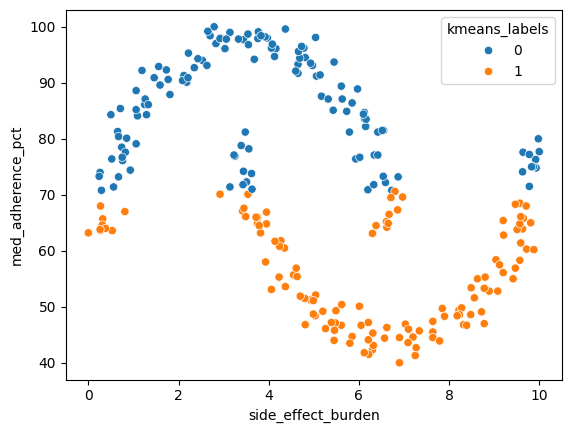

In [3]:
from sklearn.cluster import KMeans

X = meds[["side_effect_burden", "med_adherence_pct"]]

kmeans = KMeans(n_clusters=2, random_state=42)
X['kmeans_labels'] = kmeans.fit_predict(X)

sns.scatterplot(X, x='side_effect_burden', y='med_adherence_pct', hue='kmeans_labels')

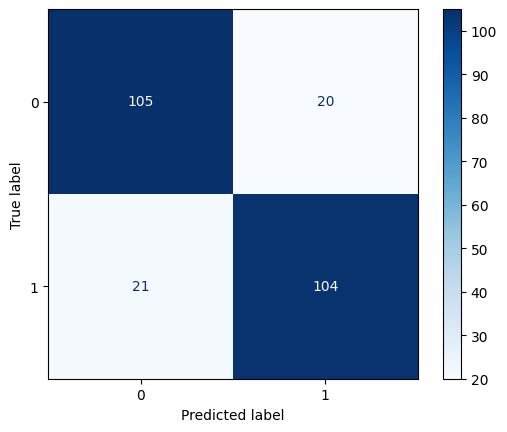

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(meds['sim_regimen'], X['kmeans_labels'], cmap="Blues")
plt.show()

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(meds['sim_regimen'], X['kmeans_labels'])
precision = precision_score(meds['sim_regimen'], X['kmeans_labels'])
recall = recall_score(meds['sim_regimen'], X['kmeans_labels'])
f1 = f1_score(meds['sim_regimen'], X['kmeans_labels'])

print(f"""
Accuracy:  {accuracy}
Precision: {precision}
Recall:    {recall}
F1:        {f1}""")


Accuracy:  0.836
Precision: 0.8387096774193549
Recall:    0.832
F1:        0.8353413654618473


## 3. Scale the data and do DBSCAN

First, we'll scale the data so the difference in scale in our two variables doesn't over-weight the distances along one axis.  Then, we'll do some exploration of **eps** and **min_samples** values to choose optimal values for our DBSCAN model.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(meds[["side_effect_burden","med_adherence_pct"]])

## Select a min_samples value

The min_samples parameter for BDSCAN is usually selected based something closed to 2 times the number of features in your data. In our case, we only two features, so 2 times 2 = 4.

In practice, you may find better performance with slightly larger or smaller numbers depending on the nature of the data itself.

## Select an eps value

In practice, we can estimate a good eps value based on a K-distance graph. First, we select the a number of neighbors (n) as our min_samples value, and then sort the points based on their distance to the the n-nearest neighbors. Plot the points in sorted order from shortest distance to longest. Where this chart bends steeply vertical shows us where there's a jump in density.

The goal here is to choose an esp value that shows a step cutoff between "most points are this close together" and "only a few points are more than this far away from their nearest neighbors."

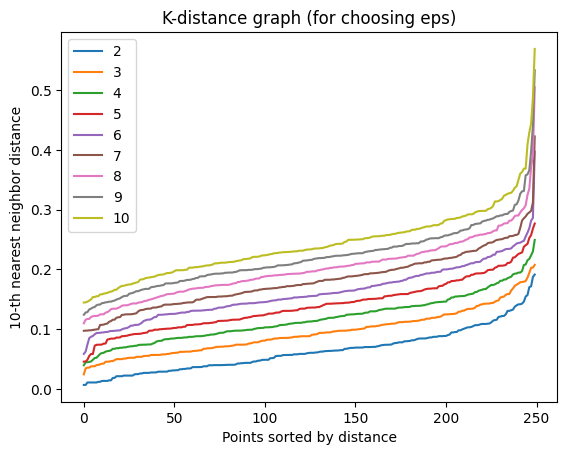

In [7]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

all_distances = pd.DataFrame()

for n in range(2,11):
    neighbors = NearestNeighbors(n_neighbors=n)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)

    distances = np.sort(distances[:,n-1])
    all_distances[n] = distances

all_distances.plot()
plt.title("K-distance graph (for choosing eps)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{n}-th nearest neighbor distance")
plt.show()

### Interpreting eps and min_samples choices

Our goal is to minimize the number of classes DBSCAN identifies, while still being >1 of course.  And minimize the number of noise points in the model.

The analysis above can give us a reasonable range of values to consider, and we can iteratively run DBSCAN to find an optimal model.

In [8]:
from sklearn.cluster import DBSCAN

min_samples = range(2,10)
eps_range = range(1,40)

dbscan_results = []

for n in min_samples:
    for eps in eps_range:
        # starting values that work well for this scaled data
        db = DBSCAN(eps=eps/10, min_samples=n)
        db_labels = db.fit_predict(X)

        unique_labels = set(db_labels)
        n_clusters = len([l for l in unique_labels if l != -1])
        n_noise = list(db_labels).count(-1)

        counts = pd.DataFrame(db_labels).value_counts()

        dbscan_results.append([n, eps/10, n_clusters, n_noise, min(counts), max(counts), min(counts)/max(counts)])

dbscan = pd.DataFrame(dbscan_results, columns=['min_samples','eps','n_clusters','noise','min_size','max_size','min_max_ratio'])


# plt.scatter(df["side_effect_burden"], df["med_adherence_pct"],
#             c=db_labels, cmap="tab10", s=30)
# plt.xlabel("Side-effect burden (0-10)")
# plt.ylabel("Medication adherence (%)")
# plt.title("DBSCAN clustering")
# plt.show()

In [9]:
dbscan

,min_samples,eps,n_clusters,noise,min_size,max_size,min_max_ratio
0,2,0.1,45,40,2,40,0.050
1,2,0.2,6,0,4,125,0.032
2,2,0.3,2,0,125,125,1.000
3,2,0.4,2,0,125,125,1.000
4,2,0.5,2,0,125,125,1.000
...,...,...,...,...,...,...,...
307,9,3.5,1,0,250,250,1.000
308,9,3.6,1,0,250,250,1.000
309,9,3.7,1,0,250,250,1.000
310,9,3.8,1,0,250,250,1.000


<Axes: xlabel='n_clusters', ylabel='noise'>

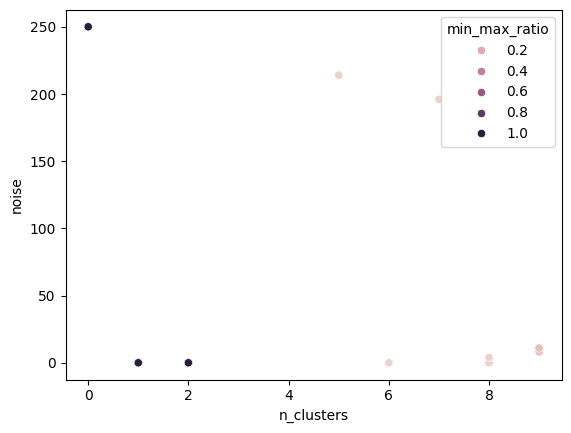

In [ ]:
# Since we want 2 clusters a min:max ratio of close to 1 (balanced between the two clusters) is good
sns.scatterplot(dbscan.query('n_clusters < 10'), x='n_clusters', y='noise', hue='min_max_ratio')

In [ ]:
# Let's find combinations of eps and min_samples that produces 
# * 2 clusters and 
# * close to a 1:1 ratio between the cluster sizes
dbscan.sort_values('min_max_ratio', ascending=False).query('n_clusters == 2')

,min_samples,eps,n_clusters,noise,min_size,max_size,min_max_ratio
200,7,0.6,2,0,125,125,1.0
199,7,0.5,2,0,125,125,1.0
198,7,0.4,2,0,125,125,1.0
197,7,0.3,2,0,125,125,1.0
161,6,0.6,2,0,125,125,1.0
160,6,0.5,2,0,125,125,1.0
159,6,0.4,2,0,125,125,1.0
158,6,0.3,2,0,125,125,1.0
278,9,0.6,2,0,125,125,1.0
277,9,0.5,2,0,125,125,1.0


Clusters: 2
Noise:    0


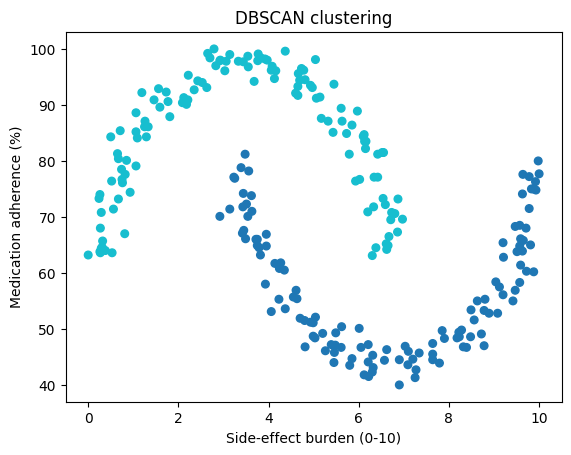

In [15]:
# starting values that work well for this scaled data

# Helper function to fit DBSCAN and plot by cluster
def dbscan_plot(X, eps, min_samples):

    db = DBSCAN(eps=eps, min_samples=min_samples)
    db_labels = db.fit_predict(X)

    unique_labels = set(db_labels)
    n_clusters = len([l for l in unique_labels if l != -1])
    n_noise = list(db_labels).count(-1)

    print(f"Clusters: {n_clusters}")
    print(f"Noise:    {n_noise}")

    plt.scatter(meds["side_effect_burden"], meds["med_adherence_pct"],
                c=db_labels, cmap="tab10", s=30)
    plt.xlabel("Side-effect burden (0-10)")
    plt.ylabel("Medication adherence (%)")
    plt.title("DBSCAN clustering")
    plt.show()

    return db_labels

# Pick som values from our table above that result in 2 clusters, 0 noise, and balanced cluster ratio
labels = dbscan_plot(X, 0.3, 4)

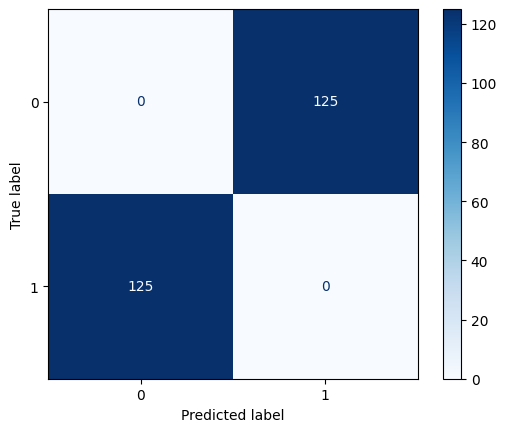

In [18]:
ConfusionMatrixDisplay.from_predictions(meds['sim_regimen'], labels, cmap="Blues")
plt.show()

### Discussion:

Does this confusion matrix tell us this is a good or bad model?

## 4. Discussion

Let's compare that to some **BAD** choices for eps and min_samples and do some evaluation of our results

Clusters: 8
Noise:    4


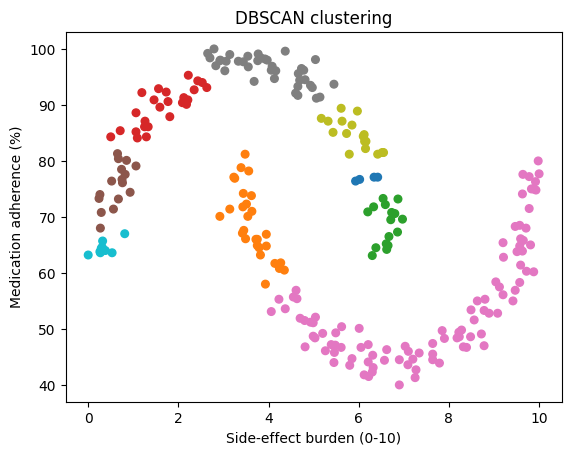

In [16]:
# Pick something that isn't on our good list above
bad_labels = dbscan_plot(X, 0.2, 5)

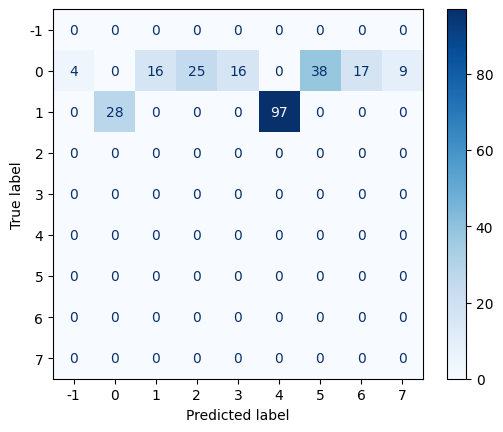

In [ ]:
ConfusionMatrixDisplay.from_predictions(meds['sim_regimen'], bad_labels, cmap="Blues")
plt.show()

### Note:

Challenges with interpretting a confusion matrix with a clustering problem:
* What do the True and Predicted labels really mean?
* In the True case, we simply use a number (0,1) to note the class... but what does that mean?
* Does a True=1 mean the same as Cluster=1?
* How do we interpret the confusion matrix when we have more than two clusters in our output?